<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 3 - Random Forest Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 1: Full Feature Set</h2>

# Table of Contents

[Introduction](#setup)  

[No Sample Weights](#noweights)

[Sample Weights](#weights)  

[Cross-Validation and Parameter Tuning](#cross-validation) 

[AdaBoost Random Forest Classifier](#ada-boost)

[Random Forest Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Random Forest classifier to the dataset. 

As always, we start with loading our standard libraries and the data

In [64]:
import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()
sns.set()
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import recall_score, f1_score, cohen_kappa_score, average_precision_score
from imblearn.metrics import specificity_score

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights)



ALGORITHM_NAME = 'rf'
COUNTRY = 'full_merged'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)

# No Sample Weights <a class="anchor" id="noweights"></a>

Now let's apply the Random Forest classifier to the dataset with no weights.

In [65]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 243 ms, sys: 0 ns, total: 243 ms
Wall time: 242 ms
CPU times: user 50.2 ms, sys: 0 ns, total: 50.2 ms
Wall time: 50.1 ms
In-sample score: 99.91%


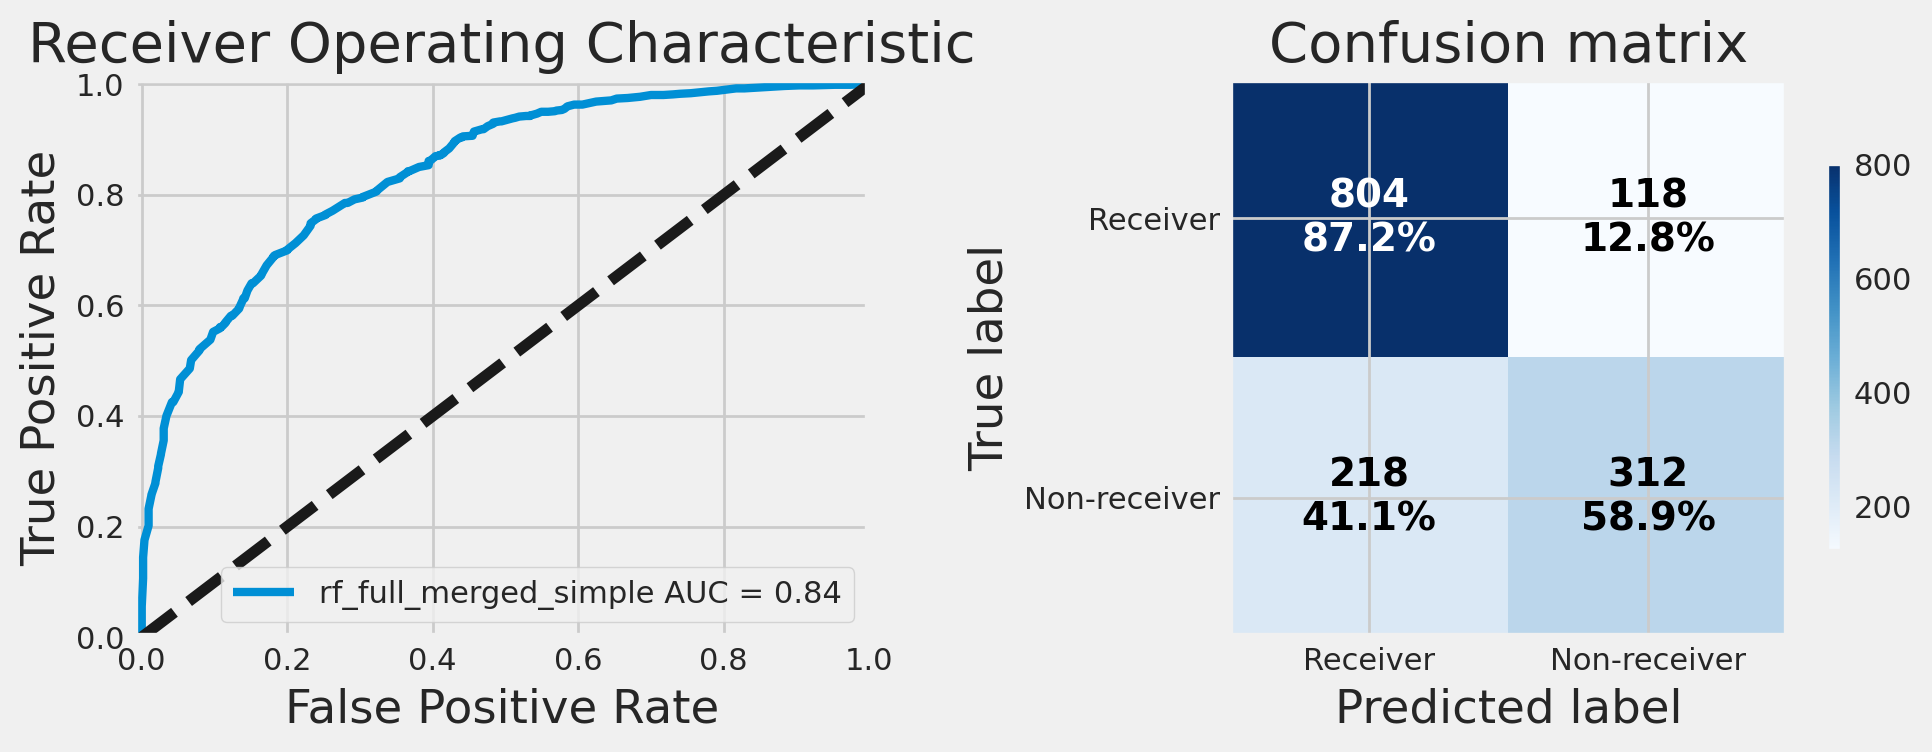

,rf_full_merged_simple
accuracy,0.768595
recall,0.872017
precision,0.786693
f1,0.827160
cross_entropy,0.462956
roc_auc,0.842918
cohen_kappa,0.479947


In [66]:
# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
X_train['age'].fillna(2.0, inplace=True)
y_train = np.ravel(y_train)
w_train = np.ravel(w_train)


# Fit the model
model = RandomForestClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
X_test['age'].fillna(2.0, inplace=True)
y_test = np.ravel(y_test)
w_test = np.ravel(w_test)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    store_model=True,
                                    model_name='full_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps,
                                    predict_dig_wage_rate=False)

In [19]:
# from sklearn.preprocessing import LabelEncoder

# categorical_cols =['economy']

# for col in categorical_cols:
#     encoder = LabelEncoder()
#     X_train[col] = encoder.fit_transform(X_train[col])
    
# X_train.economy.unique()
# X_train["economy"] = X_train["economy"].astype("category")
# X_train.info()

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 206 ms, sys: 0 ns, total: 206 ms
Wall time: 206 ms
CPU times: user 43.9 ms, sys: 0 ns, total: 43.9 ms
Wall time: 43.9 ms
In-sample score: 91.13%


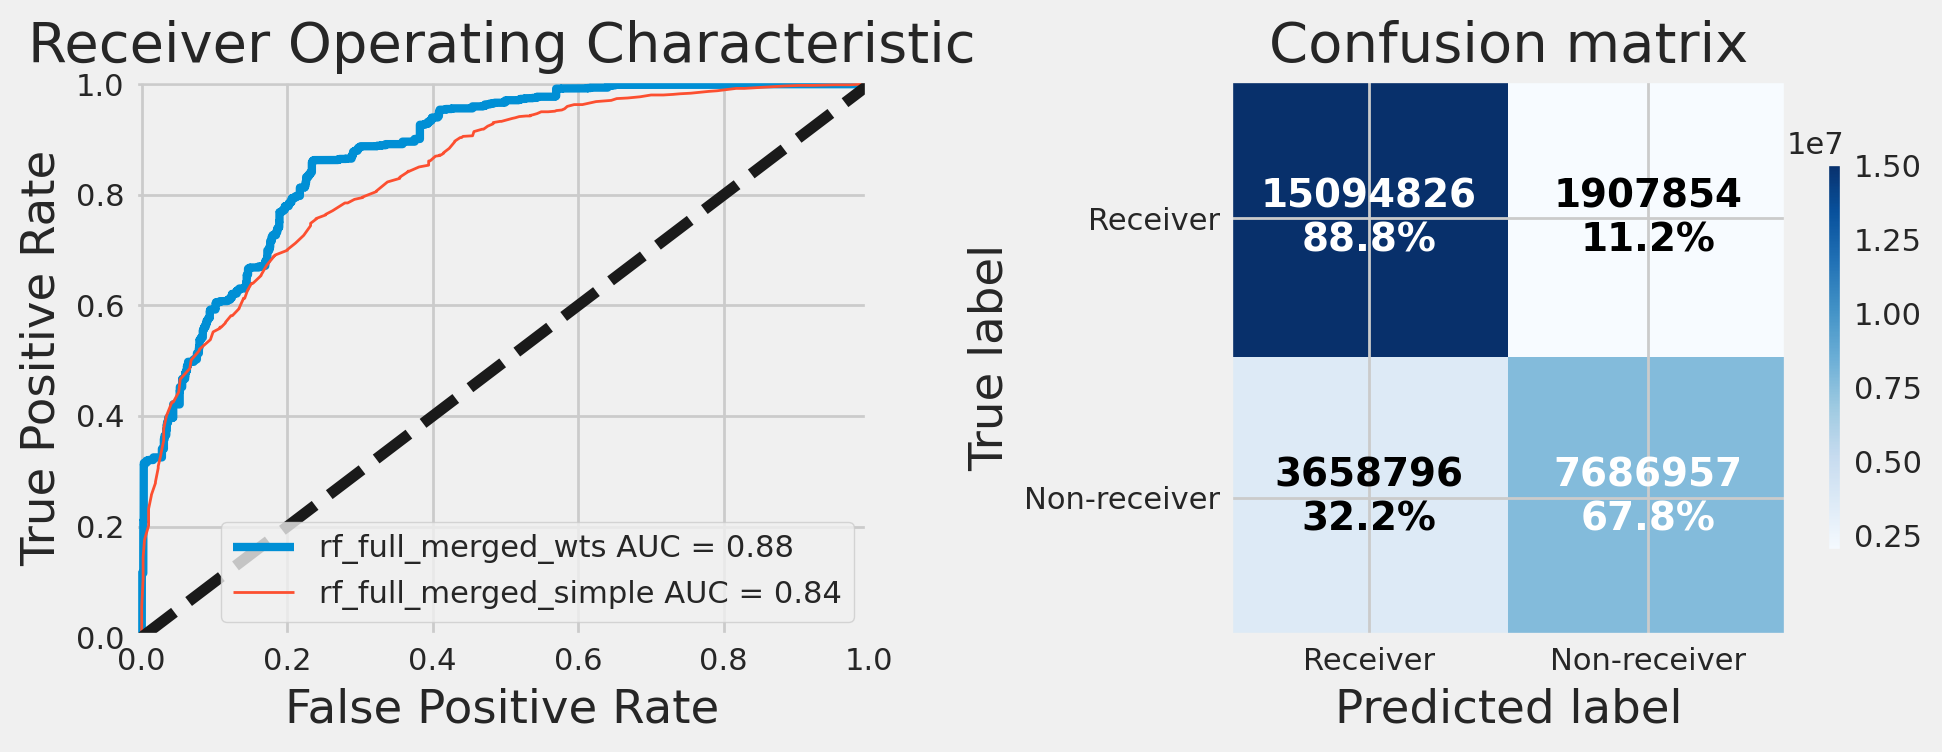

,rf_full_merged_wts,rf_full_merged_simple
accuracy,0.803635,0.768595
recall,0.887791,0.872017
precision,0.804902,0.786693
f1,0.844317,0.827160
cross_entropy,0.416539,0.462956
roc_auc,0.877444,0.842918
cohen_kappa,0.481496,0.479947


In [67]:
# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
X_train['age'].fillna(2.0, inplace=True)
y_train = np.ravel(y_train)
w_train = np.ravel(w_train)

# Fit the model
model = RandomForestClassifier(n_estimators=100, 
                               max_depth=20, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               )
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
X_test['age'].fillna(2.0, inplace=True)
y_test = np.ravel(y_test)
w_test = np.ravel(w_test)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_merged_simple'],
                                    store_model=True,
                                    model_name='full_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps,
                                    predict_dig_wage_rate=False)

## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Now we do cross-validation when fitting the  model and try to find the best parameters through hyperparameter tuning.

CPU times: user 18.5 s, sys: 761 ms, total: 19.2 s
Wall time: 3min 49s
In-sample score: 91.13%
Best model parameters: {'class_weight': {0: 0.6, 1: 0.4}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_split': 130, 'n_estimators': 125, 'random_state': 1000}


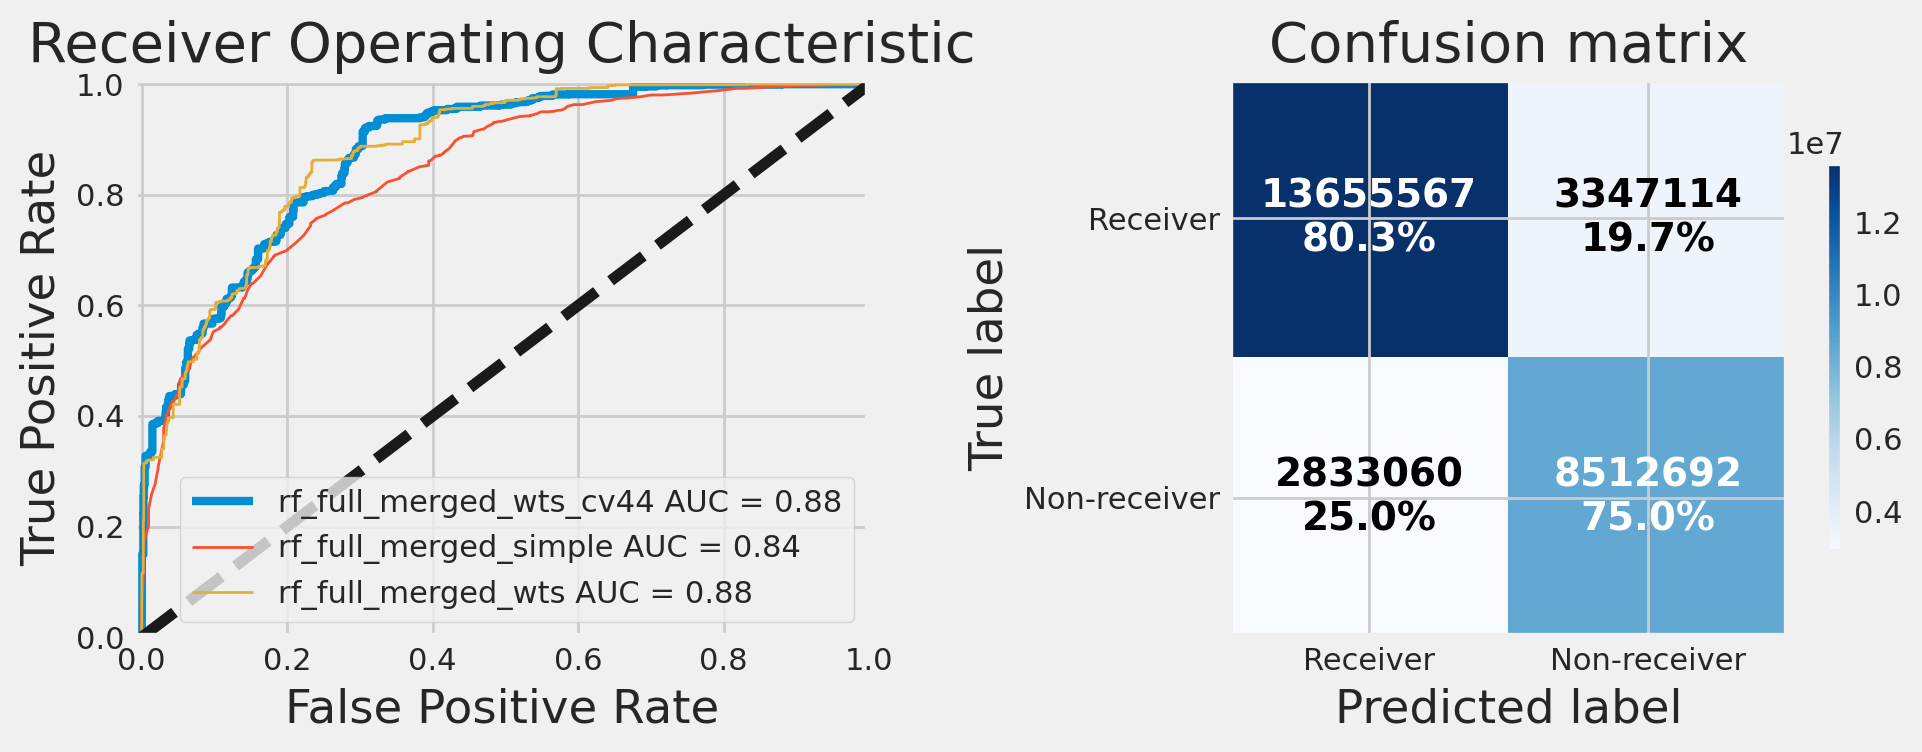

,rf_full_merged_wts_cv44,rf_full_merged_simple,rf_full_merged_wts
accuracy,0.781992,0.768595,0.803635
recall,0.803142,0.872017,0.887791
precision,0.828181,0.786693,0.804902
f1,0.815469,0.827160,0.844317
cross_entropy,0.442795,0.462956,0.416539
roc_auc,0.878008,0.842918,0.877444
cohen_kappa,0.499847,0.479947,0.481496


In [136]:
scorers = {
    'kappa': make_scorer(cohen_kappa_score),
    'f1': make_scorer(f1_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(average_precision_score),
    'specificity': make_scorer(specificity_score)
}

# Load and transform the training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)
X_train['age'].fillna(2.0, inplace=True)
y_train = np.ravel(y_train)
w_train = np.ravel(w_train)

# build the model
estimator = RandomForestClassifier(oob_score = False)
# parameters = {'n_estimators': [10, 50, 100, 150],
#               'max_depth': np.arange(1,16,5), 
#               'min_samples_split': np.arange(2,21,10),
#               'min_samples_leaf': np.arange(1,46,20)
#              }
# parameters = {'n_estimators': [125, 150, 175, 200],
#                 'criterion': ['gini', 'entropy'],
#                 'max_features': ['log2', 'sqrt', None],                            #CV4
#                  'random_state': [981], #np.arange(1,1500, 5)
#                 'max_depth': [15, 20, 30],
#                 'min_samples_split': np.arange(100,200, 10),#[100, 150, 175, 200],
#                 'class_weight': [None, {0:0.6, 1:0.4}]
#              }
parameters = {'n_estimators': [125, 150, 175, 200, 250],
                'criterion': ['gini', 'entropy'],
                'max_features': ['log2', 'sqrt', None],                        #CV44
                'random_state': [1000],
                'max_depth': [15, 20, 30],
                'min_samples_split': np.arange(100,200, 10),#[100, 150, 175, 200],
                'class_weight': [None, {0:0.6, 1:0.4}]
             }


# Use stratified KFold for the cross-validation given the imbalanced data
kf = StratifiedKFold(n_splits=3)

model = GridSearchCV(estimator, parameters, scoring=scorers, refit='precision', cv=kf, verbose=0, n_jobs=-1)
%time model.fit(X_train, y_train, sample_weight=w_train)

# Get an initial score
# %time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = split_features_labels_weights(TEST_PATH)
X_test['age'].fillna(2.0, inplace=True)
y_test = np.ravel(y_test)
w_test = np.ravel(w_test)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['rf_full_merged_simple', 
                                                    'rf_full_merged_wts'
                                                    ],
                                    store_model=True,
                                    model_name='full_merged_wts_cv44', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps,
                                    predict_dig_wage_rate=False)
best_model = model.best_estimator_

In [137]:
model.best_estimator_

RandomForestClassifier(class_weight={0: 0.6, 1: 0.4}, max_depth=15,
                       max_features='log2', min_samples_split=130,
                       n_estimators=125, random_state=1000)

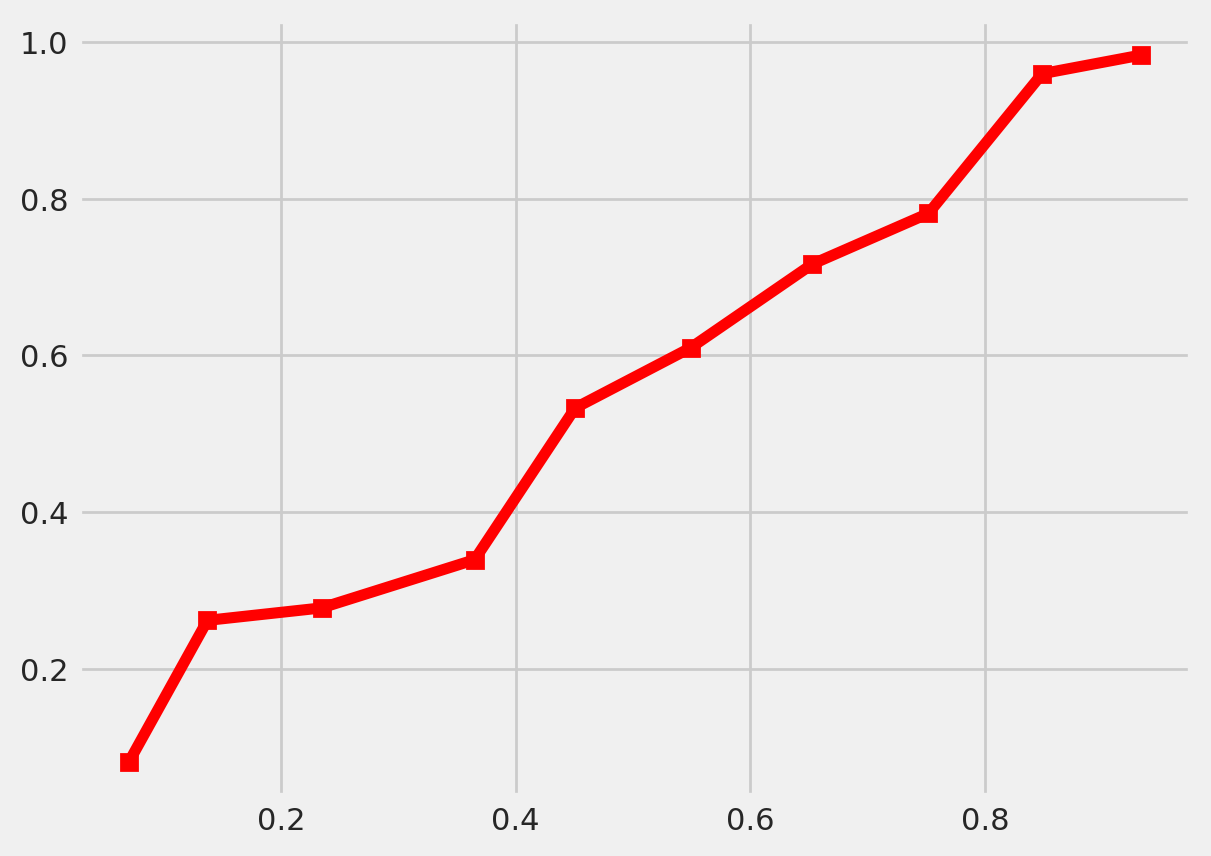

In [138]:
from sklearn.calibration import calibration_curve
y_test_predict_proba = model.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_test_predict_proba, n_bins=10)

plt.plot(mean_predicted_value, fraction_of_positives, 's-', color='red', label='Uncalibrated')


In [139]:
feat_imps.head(20)

,importance
account,0.279941
merchantpay_dig,0.135947
internet_fin_transc,0.101963
fin17a,0.098238
remittances,0.063412
fin33,0.055796
economy,0.042172
pay_utilities,0.042059
educ,0.033281
fin14_1,0.032594


# Random Forest Summary <a class="anchor" id="summary"></a>

We have covered the basic concepts of a Random Forest classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters.

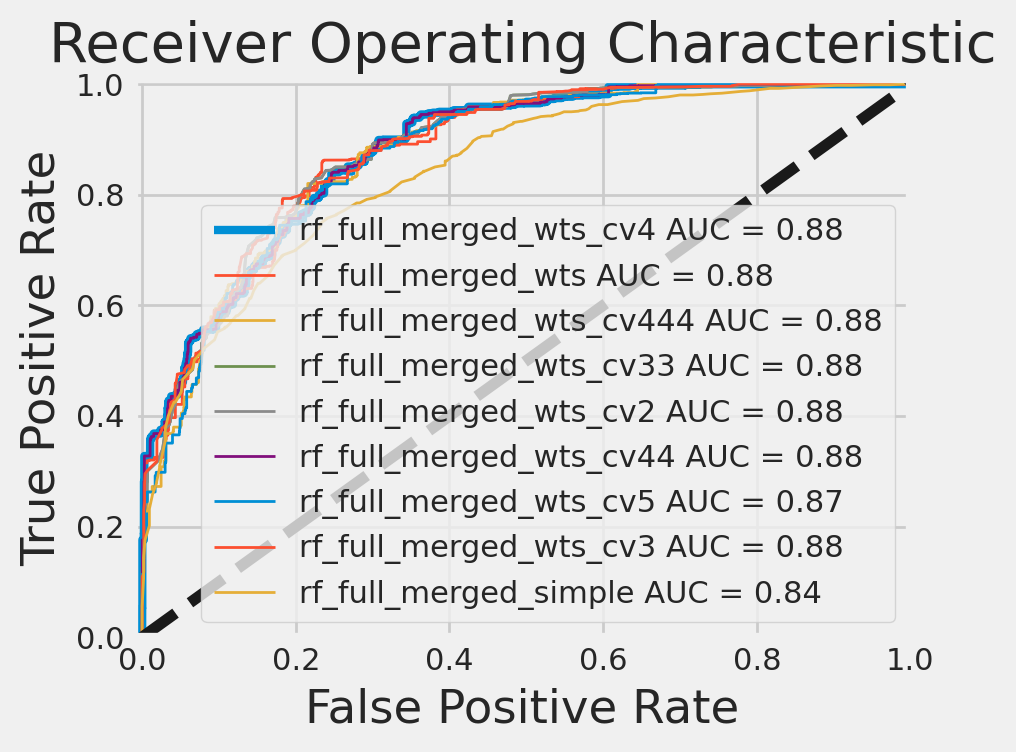

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa
rf_full_merged_wts_cv4,0.795931,0.819042,0.837187,0.828015,0.435688,0.880247,0.503439
rf_full_merged_wts,0.803635,0.887791,0.804902,0.844317,0.416539,0.877444,0.481496
rf_full_merged_wts_cv444,0.805932,0.903913,0.798937,0.848189,0.420755,0.875755,0.499356
rf_full_merged_wts_cv33,0.802781,0.859805,0.820087,0.839476,0.412372,0.881061,0.482210
rf_full_merged_wts_cv2,0.802781,0.859805,0.820087,0.839476,0.412372,0.881061,0.482210
rf_full_merged_wts_cv44,0.795931,0.819042,0.837187,0.828015,0.435688,0.880247,0.503439
rf_full_merged_wts_cv5,0.805040,0.902939,0.798401,0.847458,0.423684,0.872567,0.489019
rf_full_merged_wts_cv3,0.805576,0.872455,0.816087,0.843330,0.412952,0.882378,0.487570
rf_full_merged_simple,0.768595,0.872017,0.786693,0.827160,0.462956,0.842918,0.479947


In [125]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)